In [43]:
from glob import glob
from typing import Any, Callable, Dict, Optional

import matplotlib.pyplot as plt
import rioxarray as rxr
import torch
import torch.nn as nn
import xarray as xr
from rasterio.crs import CRS
from torchgeo.datasets.geo import RasterDataset

In [47]:
pwd

'/home/users/sofijas/WildfireDistribution'

In [44]:
%load_ext autoreload
%autoreload 2

In [45]:
plt.rcParams.update({"figure.figsize": [20, 20]})
plt.rcParams.update({"font.size": 15})

In [46]:
from src.data_loading import MODIS_JD, LandcoverComplex, LandcoverSimple

In [4]:
from torchgeo.datasets import BoundingBox

In [5]:
import os
import tempfile

from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

Loading the two datasets separately to check their details. 

In [ ]:
# creating MODIS dataset from all julian day date we have
# modis_ds = MODIS_JD("data/MODIS/*/")

In [ ]:
# print(modis_ds)

In [6]:
land_simple = LandcoverSimple("data/Classified/")

In [7]:
print(land_simple)

LandcoverSimple Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=22.944589323923992, maxx=31.80952387372908, miny=50.50130897957443, maxy=53.044619211973625, mint=0.0, maxt=9.223372036854776e+18)
    size: 1024


In [126]:
# bb = BoundingBox(23, 24.5, 51.35, 52.5, 1, 2)

# lc_sample = land_simple[bb]

# land_simple.plot(lc_sample["mask"])

In [8]:
from typing import Any, Dict, Optional

import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchgeo.samplers.batch import RandomBatchGeoSampler
from torchgeo.samplers.single import GridGeoSampler

In [9]:
from src.datamodules import MODISJDLandcoverSimpleDataModule

In [10]:
tile_size_pix = 256
sampler_size = tile_size_pix * land_simple.res

In [ ]:
# not using this at the minute, could be useful for passing a reasonable sample length

# def get_bbox_area(box):
#     return (box.maxx - box.minx) * (box.maxy - box.miny)


# sampler_len = int(get_bbox_area(ds.bounds) / (sampler_size * sampler_size))
# sampler = RandomBatchGeoSampler(
#     input_ds, size=sampler_size, batch_size=8, length=sampler_len
# )

## Loading all MODIS JD and simple landcover data using our custom made datamodule

In [11]:
# patch size is in units of CRS, the size of the sample in pixels
# corresponds to (patch_size / res)

datamodule = MODISJDLandcoverSimpleDataModule(
    modis_root_dir="data/MODIS/*/",
    landcover_root_dir="data/Classified/",
    patch_size=sampler_size,
    batch_size=5,
)

In [13]:
# this creates our dataset instance
datamodule.setup()

In [14]:
ds = datamodule.dataset

In [15]:
print(ds)

IntersectionDataset Dataset
    type: IntersectionDataset
    bbox: BoundingBox(minx=22.944589323923992, maxx=31.80952387372908, miny=50.50130897957443, maxy=53.044619211973625, mint=978307199.999999, maxt=1609459199.999999)
    size: 245760


In [16]:
train_dl = datamodule.train_dataloader()

In [17]:
for sample in train_dl:
    image = sample["image"]
    mask = sample["mask"]

In [42]:
# landcover is not an image, but this is the simplest way to make
# a distinction between predictors and targets/labels for now


# first dimension is the batch size (number of samples in batch), 
# second is the number of 'channels' (our one hot encoded layers are here)
# and the last two are the image size in pixels
image.shape, mask.shape

(torch.Size([5, 10, 256, 256]), torch.Size([5, 1, 256, 256]))

(-0.5, 255.5, 255.5, -0.5)

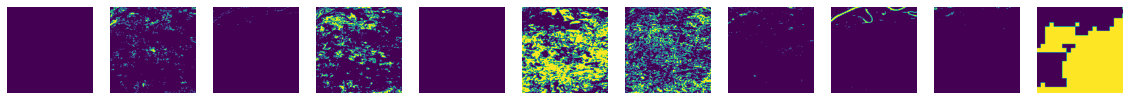

In [19]:
ncols = 11
nrows = 1

fig, axs = plt.subplots(
    nrows=1,
    ncols=ncols,
    figsize=(20, ncols * 6),
)

for i in range(ncols - 1):
    img = image[1, i, :, :]
    img = torch.squeeze(img)
    axs[i].imshow(img)
    axs[i].axis("off")

msk = mask[1, :, :, :]
msk = torch.squeeze(msk)
axs[10].imshow(msk)
axs[10].axis("off")

Questions/comments

1. Are there any other transforms that should be performed (no need to normalise etc.)
2. How to deal with all the missing data?
3. How should we create the train/test/val splits? 

## First go at using torchgeo segmentation task (this contains all the model and training logic)

In [27]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torchgeo.trainers import SemanticSegmentationTask

In [21]:
SemanticSegmentationTask?

Init signature: SemanticSegmentationTask(**kwargs: Any) -> None
Docstring:      LightningModule for semantic segmentation of images.
Init docstring:
Initialize the LightningModule with a model and loss function.

Keyword Args:
    segmentation_model: Name of the segmentation model type to use
    encoder_name: Name of the encoder model backbone to use
    encoder_weights: None or "imagenet" to use imagenet pretrained weights in
        the encoder model
    in_channels: Number of channels in input image
    num_classes: Number of semantic classes to predict
    loss: Name of the loss function
    ignore_zeros: Whether to ignore the "0" class value in the loss and metrics

Raises:
    ValueError: if kwargs arguments are invalid
File:           ~/miniconda3/envs/torchgeo/lib/python3.9/site-packages/torchgeo/trainers/__init__.py
Type:           type
Subclasses:     


In [36]:
task = SemanticSegmentationTask(
    segmentation_model="unet",
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=10,
    num_classes=1,
    loss="ce",
    ignore_zeros=True,
    learning_rate=0.1,
    learning_rate_schedule_patience=5,
)

In [28]:
experiment_dir = os.path.join(tempfile.gettempdir(), "results")

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=experiment_dir,
    save_top_k=1,
    save_last=True,
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
)

csv_logger = CSVLogger(save_dir=experiment_dir, name="tutorial_logs")

In [37]:
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=[csv_logger],
    default_root_dir=experiment_dir,
    min_epochs=1,
    max_epochs=10,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [39]:
trainer.fit(model=task, datamodule=datamodule)